In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import *
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-04-30 22:14:44.203609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 22:14:44.291833: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-30 22:14:44.653959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-30 22:14:44.654014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-30 22:14:45.196785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 22:14:45.197787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-30 22:14:45.198066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-30 22:14:45.198276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


# Goal: Estimate acceleration profile $\hat{m}$ Using Newton-Raphson to compensate for distortion between similar point clouds

Through the first order Taylor approximation we define: 

$\mathbf{h}(\hat{m})$ as the means of voxel centers in cloud $j$ passed through the distortion operator $\mathbb{C}$ according to estimated motion profile $\hat{m}$. 

$\mathbf{H}$ is the Jacobian of $\mathbf{h}$, which is multiplied by a linear correction factor $\delta m$.

$    y_i = \mathbf{h}(\hat{m}) + \mathbf{H} \delta m $


In [2]:
# load point cloud
# # no distortion
# old_cloud =  np.load("sample_data/paper_figures/case1/raw_frame_0.npy")
# # m_hat = np.array([0., 0., 0., 0., 0., 0.0]) #actual motion
# m_hat = np.array([-3., 0., 0., 0., 0., 0.1]) #test wrap around

# movement in x
old_cloud =  np.load("sample_data/paper_figures/case2/raw_frame_3.npy") 
m_hat = np.array([3, 0, 0., 0., 0., 0])
# m_hat = np.array([3, 0, 0., 0., 0., -0.2]) #FOR DEBUG-- deform just a little
gt =  np.load("sample_data/paper_figures/case2/base_vel_2.npy")

# # movement in x, y, & yaw
# old_cloud =  np.load("sample_data/paper_figures/case3/raw_frame_1.npy") 
# m_hat = np.array([3, -1, 0., 0., 0., -1])
# # m_hat = np.array([3, -1, 0.1, 0.1, 0.05, -1]) #FOR DEBUG-- deform a little extra
# gt =  np.load("sample_data/paper_figures/case3/base_vel_2.npy")
# # print(gt) 

# period_lidar = 1
# t_scale = (2*np.pi)/(-m_hat[-1] + (2*np.pi/period_lidar))
# print(t_scale)
# m_hat = m_hat*t_scale
# # m_hat[-1] = m_hat[-1]*t_scaled
# print(m_hat)


#downsample
old_cloud = old_cloud[::5,:]

In [3]:
from remove_motion_basic import linear_correction_old as lc 

new_cloud = lc(old_cloud, m_hat)
# undistorted = lc(new_cloud, -m_hat)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
# disp.append(Points(undistorted, c = "#CB2314"))
# disp.append(Points(old_cloud, c = "#CB2314"))
disp.append(Points(new_cloud, c = "#3F5151"))
plt.show(disp, "test viz")
ViewInteractiveWidget(plt.window)

/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Derive Jacobain H

### $\mathbf{H} \in \mathbb{R}^{4N \times 6} $

### $\mathbf{H} = 
\begin{bmatrix}
^{(n)}H_{x} ~ ^{(n)}H_{y} ~ ^{(n)}H_{z} ~ ^{(n)}H_{\phi} ~ ^{(n)}H_{\theta} ~ ^{(n)}H_{\psi}
\end{bmatrix}$

### $ ^{(n)}\mathbf{H}_x =  \frac{\delta{\mathbf{C}}}{\delta x} ~ ^{(n)}y_j \in \mathbb{R}^{4 \times 1}$

### Here $^{(n)}y_j$ refers to distribution mean from scan j inside voxel n, denoted in homogenous coordinates

$[x, y, z] \rightarrow [x, y, z, 1] $ 

<!-- <span style="color:red"> TODO: figure out if I need to use homogeneous coordinates for $y_j$ </span> -->

# Calculate correction  function $\mathbf{C}$ 

## $\mathbf{C}(\hat{m}) = T_{\text{rect}}(M(\hat{m})) \in \mathbb{R}^{4 \times 4} $

Here, the rectifying transformation $T_{\text{rect}}$ for each point in $y_j$ depends on scaled values of $\hat{m}$ which are concatenated to form matrix $M$. Since points are stored in the order they are recieved and are somewhat even spread throughout the scene, we can approximate $M$ through a simple linspace matrix without needing to transform to a spherical representation. $t_{\text{scale}}$ is a scaling parameter to normalize the turn rate of the sensor in the presence of composite yaw rotation.

## $
M = \bigg{(} \{ r: r = t_{\text{scale}} \frac{p}{P}, p \in \{ 0, 1, ..., P \} \} \bigg{)} \hat{m}
\in \mathbb{R}^{P \times 6}
% \begin{bmatrix}
% 1 & 1 & 1 & 1 
% \end{bmatrix}
$

## $t_{\text{scale}} = \frac{2\pi}{-\psi + \omega_{\text{LIDAR}} } $ 


My old way of "unwinding" was acomplished by converting the point cloud to spherical coordinates, rescaling the yaw angle, and then converting back to Cartesian 

<!-- ## $y_{j, \text{unwound}} =
\text{s2c} \bigg{(} \text{c2s}(y_{j})
\begin{bmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & \psi_{\text{rect}}
\end{bmatrix} \bigg{)}$
 -->
Unfortunately, c2s() is a nonlinear operation so it makes things a little tricky when we need to do everything via linear algebra

<!-- ## $ \text{c2s}(y_j) = 
\begin{bmatrix}
x_1 & y_1 & z_1 \\
x_2 & y_2 & z_2 \\
 & \vdots &
\end{bmatrix}
\rightarrow
\begin{bmatrix}
r_1 & \phi_1 & \theta_1 \\
r_2 & \phi_2 & \theta_2 \\
r_3 & \phi_3 & \theta_3
\end{bmatrix}
$
 -->
<!-- ### GPT:
lol it really got this wro

$ ^{(n)}y_j = \begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
$

$ B = \begin{bmatrix}
\text{sin}(\theta) ~ \text{cos}(\phi) & \text{cos}(\theta) ~ \text{cos}(\phi) & -\text{sin}(\phi) \\
\text{sin}(\theta)\text{sin}(\phi) & \text{cos}(\theta)\text{sin}(\phi) & \text{cos}(\phi) \\
\text{cos}(\theta) & -\text{sin}(\theta) & 0
\end{bmatrix}
$

$B ~ ^{(n)}y_j = ^{(n)}y_{j, \text{spherical}} $ -->


<!-- Putting everything together:

 $
\mathbb{C}(y_j, \hat{m}) =
M ~ T_{\text{rect}} \bigg{[} \text{s2c} \bigg{(} \text{c2s}(y_{j})
\begin{bmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & \psi_{\text{rect}}
\end{bmatrix} \bigg{)},
\begin{bmatrix}
    1 \\
    \vdots 
\end{bmatrix}
\bigg{]}^T$
 -->

In [5]:
from sympy import *

x, y, z = symbols('x y z')

init_printing(use_unicode=True)

In [6]:
period_lidar = 1
m_hat = np.array([3, 0, 0., 0., 0., -0.5])
t_scale = (2*np.pi)/(-m_hat[-1] + (2*np.pi/period_lidar))
# print(t_scale)
lsvec = np.linspace(0,t_scale, 100)

print(np.shape(m_hat))
M = m_hat * np.array([lsvec, lsvec, lsvec, lsvec, lsvec, lsvec]).T
# print(np.shape(M))
# print(M)

(6,)


## Get transform $T_{\text{rect}}$

In [7]:
x, y, z, phi, theta, psi = symbols('x y z phi theta psi')
# m_hat = Matrix([x, y, z, phi, theta, phi]).T
m_hat = np.array([1,2,3,0.4,0.5,0.6])
# print( "m_hat = ", pretty(m_hat))

T_roll = Matrix([[1, 0, 0, 0],
                 [0, cos(phi), sin(phi), 0],
                 [0, -sin(phi), cos(phi), 0],
                 [0, 0, 0, 1]])
# print("\n T_roll =") 
# print(pretty(T_roll))

T_pitch = Matrix([[cos(theta), 0, -sin(theta), 0],
                 [0, 1, 0, 0],
                 [sin(theta), 0, cos(theta), 0],
                 [0, 0, 0, 1]])
# print("\n T_pitch =") 
# print(pretty(T_pitch))

#Recall we are setting T_yaw to identity here since scan axis-aligned motion is already compensated for
T_yaw = Matrix([[cos(psi), sin(psi), 0, 0],
                 [-sin(psi), cos(psi), 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])
# print("\n T_yaw =") 
# print(pretty(T_yaw))

T_trans = Matrix([[1, 0, 0, x],
                 [0, 1, 0, y],
                 [0, 0, 1, z],
                 [0, 0, 0, 1]])
# print("\n T_trans =") 
# print(pretty(T_trans))

T_rect = (T_roll * T_pitch * T_yaw * T_trans)
# T_rect = (T_roll * T_pitch * T_yaw * T_trans).inv()
print("T_rect =")
T_rect

T_rect =


⎡           cos(ψ)⋅cos(θ)                          sin(ψ)⋅cos(θ)              
⎢                                                                             
⎢sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)  sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)   
⎢                                                                             
⎢sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)  -sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ)⋅cos(φ)  
⎢                                                                             
⎣                 0                                      0                    

   -sin(θ)                                  x⋅cos(ψ)⋅cos(θ) + y⋅sin(ψ)⋅cos(θ) 
                                                                              
sin(φ)⋅cos(θ)  x⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + y⋅(sin(φ)⋅sin(ψ)⋅sin
                                                                              
cos(φ)⋅cos(θ)  x⋅(sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)) + y⋅(-sin(φ)⋅cos(ψ) + 
                                                   

In [8]:
#try simplifying T_rect before takiking derivatives!
T_rect = simplify(T_rect)
T_rect
# print(latex(T_rect))
# print(T_rect)

⎡           cos(ψ)⋅cos(θ)                          sin(ψ)⋅cos(θ)              
⎢                                                                             
⎢sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)  sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)   
⎢                                                                             
⎢sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)  -sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ)⋅cos(φ)  
⎢                                                                             
⎣                 0                                      0                    

   -sin(θ)                                 x⋅cos(ψ)⋅cos(θ) + y⋅sin(ψ)⋅cos(θ) -
                                                                              
sin(φ)⋅cos(θ)  x⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + y⋅(sin(φ)⋅sin(ψ)⋅sin
                                                                              
cos(φ)⋅cos(θ)  x⋅(sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)) - y⋅(sin(φ)⋅cos(ψ) - s
                                                   

In [9]:
# print(diff(T_rect, x))
# diff(T_rect,y)
# print(diff(T_rect, z))
# print(diff(T_rect, psi))
# diff(T_rect, phi)
diff(T_rect, theta)
# print(diff(T_rect, theta))
# print(latex(diff(T_rect, phi)))

⎡   -sin(θ)⋅cos(ψ)        -sin(ψ)⋅sin(θ)        -cos(θ)                -x⋅sin(
⎢                                                                             
⎢sin(φ)⋅cos(ψ)⋅cos(θ)  sin(φ)⋅sin(ψ)⋅cos(θ)  -sin(φ)⋅sin(θ)  x⋅sin(φ)⋅cos(ψ)⋅c
⎢                                                                             
⎢cos(φ)⋅cos(ψ)⋅cos(θ)  sin(ψ)⋅cos(φ)⋅cos(θ)  -sin(θ)⋅cos(φ)  x⋅cos(φ)⋅cos(ψ)⋅c
⎢                                                                             
⎣         0                     0                  0                          

θ)⋅cos(ψ) - y⋅sin(ψ)⋅sin(θ) - z⋅cos(θ)          ⎤
                                                ⎥
os(θ) + y⋅sin(φ)⋅sin(ψ)⋅cos(θ) - z⋅sin(φ)⋅sin(θ)⎥
                                                ⎥
os(θ) + y⋅sin(ψ)⋅cos(φ)⋅cos(θ) - z⋅sin(θ)⋅cos(φ)⎥
                                                ⎥
               0                                ⎦

In [10]:
# # print(T_rect) # -> take printed output and convert to numpy array

# # from tensorflow.math import sin, cos
# from numpy import sin, cos

# x = np.array([1,2,3])#[:,None]
# y = np.array([1,2,3])#[:,None]
# z = np.array([1,2,3])#[:,None]
# phi = np.array([1,2,3])#[:,None]
# theta = np.array([1,2,3])#[:,None]
# psi = np.array([1,2,3])#[:,None]
# test = np.array([cos(x) * cos(y) / sin(phi), cos(x) * cos(y) / sin(phi)])
# print(np.shape(test))
# print(test)

# T_rect_np = np.array([[cos(psi)*cos(theta)/(sin(psi)**2*sin(theta)**2 + sin(psi)**2*cos(theta)**2 + sin(theta)**2*cos(psi)**2 + cos(psi)**2*cos(theta)**2), (sin(phi)*sin(theta)*cos(psi) - sin(psi)*sin(theta)**2*cos(phi) - sin(psi)*cos(phi)*cos(theta)**2)/(sin(phi)**2*sin(psi)**2*sin(theta)**2 + sin(phi)**2*sin(psi)**2*cos(theta)**2 + sin(phi)**2*sin(theta)**2*cos(psi)**2 + sin(phi)**2*cos(psi)**2*cos(theta)**2 + sin(psi)**2*sin(theta)**2*cos(phi)**2 + sin(psi)**2*cos(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2*cos(psi)**2 + cos(phi)**2*cos(psi)**2*cos(theta)**2), (sin(phi)*sin(psi)*sin(theta)**2 + sin(phi)*sin(psi)*cos(theta)**2 + sin(theta)*cos(phi)*cos(psi))/(sin(phi)**2*sin(psi)**2*sin(theta)**2 + sin(phi)**2*sin(psi)**2*cos(theta)**2 + sin(phi)**2*sin(theta)**2*cos(psi)**2 + sin(phi)**2*cos(psi)**2*cos(theta)**2 + sin(psi)**2*sin(theta)**2*cos(phi)**2 + sin(psi)**2*cos(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2*cos(psi)**2 + cos(phi)**2*cos(psi)**2*cos(theta)**2), -x], [sin(psi)*cos(theta)/(sin(psi)**2*sin(theta)**2 + sin(psi)**2*cos(theta)**2 + sin(theta)**2*cos(psi)**2 + cos(psi)**2*cos(theta)**2), (sin(phi)*sin(psi)*sin(theta) + sin(theta)**2*cos(phi)*cos(psi) + cos(phi)*cos(psi)*cos(theta)**2)/(sin(phi)**2*sin(psi)**2*sin(theta)**2 + sin(phi)**2*sin(psi)**2*cos(theta)**2 + sin(phi)**2*sin(theta)**2*cos(psi)**2 + sin(phi)**2*cos(psi)**2*cos(theta)**2 + sin(psi)**2*sin(theta)**2*cos(phi)**2 + sin(psi)**2*cos(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2*cos(psi)**2 + cos(phi)**2*cos(psi)**2*cos(theta)**2), (-sin(phi)*sin(theta)**2*cos(psi) - sin(phi)*cos(psi)*cos(theta)**2 + sin(psi)*sin(theta)*cos(phi))/(sin(phi)**2*sin(psi)**2*sin(theta)**2 + sin(phi)**2*sin(psi)**2*cos(theta)**2 + sin(phi)**2*sin(theta)**2*cos(psi)**2 + sin(phi)**2*cos(psi)**2*cos(theta)**2 + sin(psi)**2*sin(theta)**2*cos(phi)**2 + sin(psi)**2*cos(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2*cos(psi)**2 + cos(phi)**2*cos(psi)**2*cos(theta)**2), -y], [-sin(theta)/(sin(theta)**2 + cos(theta)**2), sin(phi)*cos(theta)/(sin(phi)**2*sin(theta)**2 + sin(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2 + cos(phi)**2*cos(theta)**2), cos(phi)*cos(theta)/(sin(phi)**2*sin(theta)**2 + sin(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2 + cos(phi)**2*cos(theta)**2), -z], 
#                       [np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x)), np.ones(len(x))]])
# print(np.shape(T_rect_np))
# test = np.transpose(T_rect_np, (2,0,1))
# print(test)

In [11]:
# y_j = y_j[:3]
# if np.shape(y_j)[1] == 3:
#     y_j = np.append(y_j, np.ones([len(y_j),1]), axis = 1)

# # y_j_tf = tf.convert_to_tensor(y_j[:,:,None])
# # test_tf = tf.convert_to_tensor(test)
# # print(np.shape(y_j_tf))
# # print(np.shape(test_tf))

# # ans = y_j_tf * test_tf

# print(np.shape(y_j[:,:,None]))
# print(np.shape(test))
# # ans = y_j[:,:,None] * test
# ans = test @ y_j[:,:,None]


# print(np.shape(ans))
# print(ans)
# ans = np.reshape(ans, (-1, 1))
# print(ans)

In [12]:
# diff(T_rect, x)
diff(T_rect, phi)

# dT_rect_dx = diff(T_rect, x)
# pprint(dT_rect_dx)

⎡                  0                                      0                   
⎢                                                                             
⎢sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)   -sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ)⋅cos(φ) 
⎢                                                                             
⎢-sin(φ)⋅sin(θ)⋅cos(ψ) + sin(ψ)⋅cos(φ)  -sin(φ)⋅sin(ψ)⋅sin(θ) - cos(φ)⋅cos(ψ) 
⎢                                                                             
⎣                  0                                      0                   

       0                                                           0          
                                                                              
 cos(φ)⋅cos(θ)   x⋅(sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)) + y⋅(-sin(φ)⋅cos(ψ) 
                                                                              
 -sin(φ)⋅cos(θ)  x⋅(-sin(φ)⋅sin(θ)⋅cos(ψ) + sin(ψ)⋅cos(φ)) - y⋅(sin(φ)⋅sin(ψ)⋅
                                                   

In [13]:
#substitue in values
expr = diff(T_rect, phi)
# print(expr)
# expr = T_rect
# print(m_hat)
ans = expr.subs([(x, m_hat[0]), 
                 (y, m_hat[1]),
                 (z, m_hat[2]),
                 (phi, m_hat[3]),
                 (theta, m_hat[4]),
                 (psi, m_hat[5])])
print(type(np.array(ans)))
print("\n", np.array(ans).astype(np.float64))

<class 'numpy.ndarray'>

 [[ 0.          0.          0.          0.        ]
 [ 0.58433397 -0.07206591  0.80830707  2.86512335]
 [ 0.36598239 -0.86560155 -0.34174675 -2.39046095]
 [ 0.          0.          0.          0.        ]]


# Test rectifying motion distortion usuing SymPy Linalg technique

In [14]:
from remove_motion_basic import get_H
from remove_motion_basic import linear_correction_old as lc 

m_hat = np.array([3, 0, 0, 0, 0, 0])
skip = 1
y_j = old_cloud[::skip]
# y_j = old_cloud[::skip] + np.array([0.5, 0.5, 0.]) #test offset - hurts performance but doesn't cause anything to explode
y_i = new_cloud[::skip] #has distortion already corrected

# #remove ground plane
# y_i = y_i[y_i[:,2] > -1]
# y_j = y_j[y_j[:,2] > -1]

H = get_H(y_j = y_j, m_hat = m_hat )

#plot result
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(y_i, c = "#CB2314", r=3.5))
disp.append(Points(y_j, c = "#3F5151", r=3.5))
plt.show(disp, "test viz")
ViewInteractiveWidget(plt.window)

/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [15]:
print(np.shape(H))
print(np.shape(y_j)[0]*4)

(72296, 6)
72296


# Simple Test using pre-rectified point cloud
#### in this example we don't need to worry about iteratively finding correspondences
(y_i and y_j are the same length and are ordered accordingly) 

In [16]:
#assume initial correction factor of 0 for each solution component
m_hat = np.array([0., 0, 0, 0, 0, 0])
skip = 1 #50
y_i = new_cloud[::skip] #baseline
y_j = old_cloud[::skip] #distorted cloud
# y_j = old_cloud[::skip] + np.array([0.5, 0.5, 0.]) #test offset - hurts performance but doesn't cause anything to explode

# #add noise 
# noise_scale = 0.01
# y_i += np.random.randn(np.shape(y_i)[0],np.shape(y_i)[1])*noise_scale 
# y_j += np.random.randn(np.shape(y_j)[0],np.shape(y_j)[1])*noise_scale 

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(y_i[:,:3], c = "#2c7c94 ", alpha = 1, r=3.5))

runlen = 10
for count in range(runlen):
    
    print("~~~~ iteration ", count, "~~~~~~~~~~~")
    print("m_hat = ", m_hat)
    
    #apply last estimate of correction
    y_j_undistort = lc(y_j, m_hat)
    print(np.shape(y_j_undistort))
    
    #delta_m =  ((H^T*H)^-1)(H^T)(yi - yj*)
    try:
        H = dc.get_H_m(y_j_undistort, m_hat) #direclty use from distortion corrector object
    except:
        H = get_H(y_j_undistort, m_hat) #from old test script
    residual = (np.append(y_i, np.ones([len(y_i),1]), axis = 1) -
                np.append(y_j_undistort, np.ones([len(y_i),1]), axis = 1)).flatten()
    print("residual", np.shape(residual))
    delta_m = np.linalg.pinv(H.T @ H) @ H.T @ residual
    m_hat[:3] -= delta_m[:3]
    m_hat[3:] += delta_m[3:] #TODO: figure out why angles are backwards...    
    
    #plot updated cloud2
#     color = [0.5 + count/(runlen*2), 1 - count/runlen, count/runlen]
    disp.append(Points(y_j_undistort[:,:3], c = "#a65852 ", alpha = (count+1)/(runlen+1), r=3.5))

    
plt.show(disp, "test viz")
ViewInteractiveWidget(plt.window)

~~~~ iteration  0 ~~~~~~~~~~~
m_hat =  [0. 0. 0. 0. 0. 0.]
(18074, 3)
residual (72296,)
~~~~ iteration  1 ~~~~~~~~~~~
m_hat =  [ 1.50076306e+00  2.26629200e-02  5.68033178e-05 -6.33888529e-04
 -8.43187272e-05  4.21560810e-02]
(18074, 3)
residual (72296,)
~~~~ iteration  2 ~~~~~~~~~~~
m_hat =  [ 2.18840459e+00  3.84588640e-03 -9.59454424e-04 -7.65024582e-04
 -5.09889622e-04  4.12991874e-02]
(18074, 3)
residual (72296,)
~~~~ iteration  3 ~~~~~~~~~~~
m_hat =  [ 2.53057160e+00 -8.36884636e-03 -1.82734948e-03 -6.43131527e-04
 -6.77084844e-04  3.11388189e-02]
(18074, 3)
residual (72296,)
~~~~ iteration  4 ~~~~~~~~~~~
m_hat =  [ 2.71630260e+00 -1.25108997e-02 -2.11191968e-03 -4.76898944e-04
 -6.50091103e-04  2.14916532e-02]
(18074, 3)
residual (72296,)
~~~~ iteration  5 ~~~~~~~~~~~
m_hat =  [ 2.82402023e+00 -1.22303351e-02 -1.97690668e-03 -3.36511515e-04
 -5.38386531e-04  1.42884138e-02]
(18074, 3)
residual (72296,)
~~~~ iteration  6 ~~~~~~~~~~~
m_hat =  [ 2.88921274e+00 -1.01981138e-02 -1.65

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [17]:
#TEST-- try scaling elements of H_m proportional to the azimuth angle of their assoicated distribution centers
# H = dc.H
# M = dc.M
# print(np.shape(M))
# print(np.shape(H))

a = np.array([[1,1],[2,2],[3,3]])
b = np.repeat(a, repeats=4, axis = 0)
print(b)

[[1 1]
 [1 1]
 [1 1]
 [1 1]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [3 3]
 [3 3]
 [3 3]
 [3 3]]


# Test using spherical voxels to form distributions

In [ ]:
#DEBUG: convert <apply_motion_profile> to linalg 
pc1 = new_cloud
pc2 = old_cloud
## only take first part of cloud
# pc1 = new_cloud[:5000]
# pc2 = old_cloud[:5000]
# # remove ground plane
# pc1 = new_cloud[new_cloud[:,2] > -1]
# pc2 = old_cloud[old_cloud[:,2] > -1]

# m_hat = np.array([3, -1, 0, 0, 0, -1])
# pc1 = new_cloud + 0.01*np.random.randn(np.shape(new_cloud)[0],3)
# m_hat = np.array([0, 0, 0, 0.2, 0, 0])
# pc2 = dc.apply_motion_profile(old_cloud, m_hat)

plt2 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(pc1,  c = 'red'))
disp.append(Points(pc2, c = 'blue'))
plt2.show(disp, "test viz")
ViewInteractiveWidget(plt2.window)

In [29]:
from linear_corrector import LC

m_hat0 = np.array([0.,0, 0, 0, 0, 0]) #cold start
dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 20, draw = True, m_hat0 = m_hat0,  mnp = 25, RM = False)
ViewInteractiveWidget(dc.plt.window)

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.027102947235107422 sec  to apply motion profile

 M 
 (210, 6)
H_m 
 (840, 6)
took 0.006791353225708008 sec to get H
m_hat:  [ 0.52337128  0.03528726  0.0127036  -0.00183924  0.00460828  0.01445822]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.024934768676757812 sec  to apply motion profile

 M 
 (213, 6)
H_m 
 (852, 6)
took 0.004027605056762695 sec to get H
m_hat:  [ 0.69005609 -0.00805727  0.00654595 -0.00316998  0.00584856  0.00793633]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.02698516845703125 sec  to apply motion profile

 M 
 (214, 6)
H_m 
 (856, 6)
took 0.004385709762573242 sec to get H
m_hat:  [ 0.73906541 -0.01551717 -0.0010637  -0.00439862  0.00606193  0.00638997]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.02473282814025879 sec  to apply motion profile

 M 
 (215, 6)
H_m 
 (860, 6)
took 0.004142284393310547 sec to get H
m_hat:  [ 0.74956882 -0.03433084 -0.01267686 -0.00678898  0.00668124  0.00584266]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
too

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [ ]:
#for debug linear scaling
# print(dc.yaw_angs_old)
# print(dc.yaw_angs_new)

# fig, ax = plt.subplots()
# ax.plot(dc.yaw_angs_old, label = "yaw_angs old")
# ax.plot(dc.yaw_angs_new, label = "yaw_angs new")
# ax.legend(loc = 'best')

In [ ]:
# #debug for vectorized <apply_motion_profile()>
# from numpy import sin, cos

# M = dc.motion_profile

# x = M[:,0]
# y = M[:,1]
# z = M[:,2]
# phi = M[:,3]
# theta = M[:,4]
# psi = M[:,5]

# T_rect_numpy = np.array([[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi), sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi), -x], [sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi), -y], [-sin(theta), sin(phi)*cos(theta), cos(phi)*cos(theta), -z], [np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x)), np.ones(len(x))]])
# T_rect_numpy = np.transpose(T_rect_numpy, (2,0,1))
# # print(T_rect_numpy)
# print(np.shape(T_rect_numpy))

# pc = np.append(old_cloud, np.ones([len(old_cloud),1]), axis=1)
# print(np.shape(pc))

# # T_rect_numpy = np.reshape(T_rect_numpy, (-1, 4))
# # print(T_rect_numpy)
# # print(np.shape(T_rect_numpy))

# # ans =  T_rect_numpy @ pc[:,:,None]
# # print(np.shape(ans[:,:,0]))

In [ ]:
# print(M[::100,0])
# print(dc.cloud1_tensor)

#convert to spherical coordinates and plot theta angles-- see how evenly distributed they are for various scenes
pc1_spherical = dc.c2s(pc1)
pc2_spherical = dc.c2s(pc2)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
# yaw_angs = pc2_spherical[:,1].numpy() #has step func
# yaw_angs = (pc2_spherical[:,1] + 2*np.pi ) % (2*np.pi)  #has trouble with noise

yaw_angs = pc2_spherical[:,1].numpy()
last_subzero_idx = int(len(yaw_angs) // 8)
yaw_angs[last_subzero_idx:][yaw_angs[last_subzero_idx:] < 0.3] = yaw_angs[last_subzero_idx:][yaw_angs[last_subzero_idx:] < 0.3] + 2*np.pi

# yaw_angs = np.tan(np.arctan2(pc2_spherical[:,1].numpy(), 1))

M_naive = 2 * np.pi * np.linspace(0, len(yaw_angs)-1, len(yaw_angs)) / len(yaw_angs)

ax.set_title("Goodness of linearly interpolating $\hat{m}$ to M: Ford")
ax.set_xlabel("point idx")
ax.set_ylabel("yaw angle")
ax.plot(yaw_angs, label = "actual yaw angles")
ax.plot(M_naive, label = "linearly interpolated M")
ax.legend(loc='best')

In [ ]:
# #test how long cartesian -> spherical takes
# st = time.time()
# for i in range(100):
#     dummy_pc = np.random.randn(10_0000, 3)
#     ans = dc.c2s(dummy_pc)
# print("took", (time.time()-st)/100)

# Try distortion correction on Ford Campus Datset

#### TODO: I think we need a pretty stringent moving object removal filter before estimating motion distortion in LIDAR real world point clouds

<IPython.core.display.Javascript object>


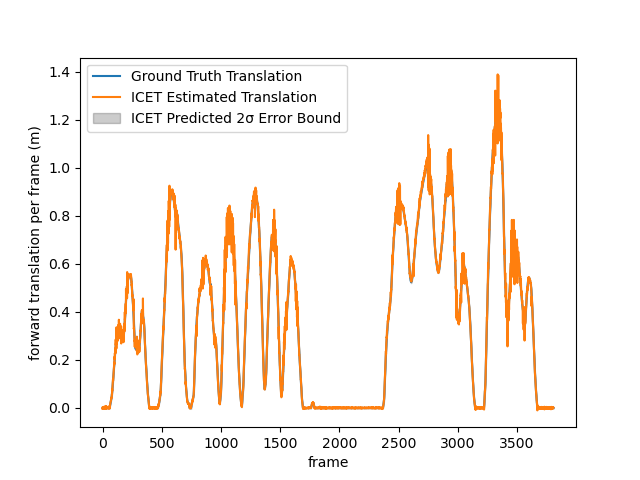

In [18]:
#load ICET results
estimates = np.loadtxt("../results/Ford_full_estimates_v10.txt")
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
runlen = np.shape(estimates)[0]
estimates = estimates[1:,:]
pred_stds = pred_stds[1:,:]
vf = (ground_truth[:runlen-1,1]/10 + ground_truth[1:runlen,1]/10)/2 #v5

#plot ground truth vs raw ICET estimates
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(vf, label = 'Ground Truth Translation')
# print(estimates[:,0])
ax.plot(estimates[:,1], label = "ICET Estimated Translation") #was this
#NOTE-- adjust linspace here when shifting
ax.fill_between(np.linspace(0,runlen-2,runlen-1),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'ICET Predicted 2σ Error Bound')
ax.set_xlabel("frame")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

In [57]:
#load point clouds
import mat4py
#full dataset starts at 00136
# i = 1075 # correction of 0.15cm, similar error
# i = 1071 # correction of 5.0 cm, similar error
# i = 1450

i = 1072 # HUGE distortion

# i = 710

fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+75) #75 + 61 = 136
fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+76) #76 + 61 = 137

dat1 = mat4py.loadmat(fn1)
SCAN1 = dat1['SCAN']
pc1 = np.transpose(np.array(SCAN1['XYZ']))

dat2 = mat4py.loadmat(fn2)
SCAN2 = dat2['SCAN']
pc2 = np.transpose(np.array(SCAN2['XYZ']))

ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
gt = (ground_truth[i,:] + ground_truth[i+1,:])/2 #avg between pts

#flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
pc1 = np.flip(pc1, axis = 0)
pc2 = np.flip(pc2, axis = 0)
#need to rotate point clouds so the scan starts aligned with +x axis
rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
pc1 = pc1 @ rot
pc2 = pc2 @ rot
#ignore ground plane
# c1 = c1[c1[:,2] > -2.2]
# c2 = c2[c2[:,2] > -2.2] 

In [58]:
#run ICET to get initial transforms of point clouds
it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
           draw = True, group = 2, RM = True, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.9265229e-01 -8.6983452e-03 -4.8381006e-03 -2.4239607e-03
  1.3395079e-03  2.8505459e-04], shape=(6,), dtype=float32)

 predicted standard deviations of error: 
 tf.Tensor(
[2.1759646e-03 1.8105956e-03 2.2866363e-04 2.7900072e-05 3.4562843e-05
 2.0672474e-04], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [59]:
# #apply output of ICET to raw point clouds
# trans = it.X[:3].numpy()
# rot = R_tf(-it.X[3:]).numpy().T
# pc2_transformed =  (pc2 @ rot) + trans 

#apply "ground truth" transform to point clouds
trans = np.array([gt[1], gt[0], gt[2]])
rot = R_tf(-gt[3:]).numpy().T
pc2_transformed =  (pc2 @ rot) + trans 

In [60]:
# #for debug: inject exaggerated distortion to one of the clouds
# m_hat_distort = np.array([0., 0.,0., 0., 0., 0.])
# pc2_transformed = lc(pc2_transformed, m_hat_distort)

plt3 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(pc1,  c = 'red'))
# disp.append(Points(pc2[:50_000], c = 'blue')) #test to see which direction sensor is spinning
disp.append(Points(pc2_transformed, c = 'blue'))
plt3.show(disp, "test viz")
ViewInteractiveWidget(plt3.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [50]:
m_hat0 = np.array([0.,0, 0, 0, 0, 0])
dc = LC(cloud1 = pc1, cloud2 = pc2_transformed, fid = 50, niter = 4, draw = True, m_hat0 = m_hat0, RM = True)
ViewInteractiveWidget(dc.plt.window)

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.023395538330078125 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 0.0022106170654296875 sec to get H
m_hat:  [-0.08431118 -0.01231715 -0.00705152  0.00113524  0.00206036  0.00060698]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.02374410629272461 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 0.0022649765014648438 sec to get H
m_hat:  [-0.09213474 -0.01577608 -0.00717486  0.00133802  0.0021627   0.00070397]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.025110483169555664 sec  to apply motion profile

 M 
 (201, 6)
H_m 
 (804, 6)
took 0.002395153045654297 sec to get H
m_hat:  [-0.09311394 -0.01647376 -0.00717613  0.0013635   0.00216009  0.00073243]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.02258920669555664 sec  to apply motion profile

 M 
 (201, 6)
H_m 
 (804, 6)
took 0.003960371017456055 sec to get H
m_hat:  [-0.09320147 -0.01651036 -0.00717848  0.00136732  0.00216075  0.00073586]


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [31]:
print(gt.numpy())
print(it.X.numpy())

[ 0.0000000e+00  7.5868797e-01  3.6267645e-03 -3.1409808e-03
 -8.5096044e-04  2.9040070e-04]
[ 0.6874241   0.00117986 -0.0043757  -0.00235275  0.00131263  0.00083523]


In [68]:
#Putting it  all together - use distortion corrector to create error bounds

start_idx = 1025 #990 #start on this scan
runlen = 25 #250
m_hat_history = np.zeros([runlen, 6])

for i in range(runlen):
    print("------------------------- SCAN IDX", i + start_idx,"-------------------------------------")

    #load point clouds
    fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+75)
    fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+76)
    dat1 = mat4py.loadmat(fn1)
    SCAN1 = dat1['SCAN']
    pc1 = np.transpose(np.array(SCAN1['XYZ']))
    dat2 = mat4py.loadmat(fn2)
    SCAN2 = dat2['SCAN']
    pc2 = np.transpose(np.array(SCAN2['XYZ']))

    #align point clouds using ground truth
    ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
    ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
    gt = (ground_truth[i+start_idx,:] + ground_truth[i+start_idx+1,:])/2 #avg between pts
    print("\n GT: \n", gt)
        
    #flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
    pc1 = np.flip(pc1, axis = 0)
    pc2 = np.flip(pc2, axis = 0)
    #need to rotate point clouds so the scan starts aligned with +x axis
    rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
    pc1 = pc1 @ rot
    pc2 = pc2 @ rot

    #apply "ground truth" transform to point clouds
    trans = np.array([gt[1], gt[0], gt[2]])
    trans[0] += 0.01 #add noise to x
    rot = R_tf(-gt[3:]).numpy().T
    pc2_transformed =  (pc2 @ rot) + trans 

#     #apply output of ICET to raw point clouds ~~~~~~~~~~~~~~~~~~~
#     #align point clouds using ICET output, seed ICET input with ground truth to ensure convergence
#     it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = False, group = 2, RM = True, DNN_filter = False, x0 = gt)
#     #ViewInteractiveWidget(it.plt.window)
#     gt = it.X
#     trans = it.X[:3].numpy()
#     rot = R_tf(-it.X[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    #run distortion correction
    m_hat0 = np.array([0.,0, 0, 0, 0, 0])
    dc = LC(cloud1 = pc1, cloud2 = pc2_transformed, fid = 50, niter = 10, draw = False, m_hat0 = m_hat0, RM = True)

#     print(dc.m_hat)
    m_hat_history[i,:] = dc.m_hat
    


------------------------- SCAN IDX 1025 -------------------------------------

 GT: 
 tf.Tensor(
[ 0.0000000e+00  4.6681225e-01 -2.2447172e-03  3.3941527e-04
 -1.2427575e-03  2.1035141e-04], shape=(6,), dtype=float32)
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.023678064346313477 sec  to apply motion profile

 M 
 (203, 6)
H_m 
 (812, 6)
took 0.0026085376739501953 sec to get H
m_hat:  [-0.03903495 -0.01174499  0.00028472 -0.00178917  0.00035382  0.00101211]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.025441408157348633 sec  to apply motion profile

 M 
 (202, 6)
H_m 
 (808, 6)
took 0.005157947540283203 sec to get H
m_hat:  [-0.04588642 -0.01281608  0.00052626 -0.00191297  0.00046116  0.00104735]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.024378299713134766 sec  to apply motion profile

 M 
 (202, 6)
H_m 
 (808, 6)
took 0.0054395198822021484 sec to get H
m_hat:  [-0.04714087 -0.01298575  0.00057333 -0.00192426  0.00049545  0.00099777]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.024070024490356


 M 
 (202, 6)
H_m 
 (808, 6)
took 0.0026443004608154297 sec to get H
m_hat:  [-0.04171306 -0.0057161  -0.00996945 -0.00548992  0.00199002  0.00134414]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.02316570281982422 sec  to apply motion profile

 M 
 (202, 6)
H_m 
 (808, 6)
took 0.0024673938751220703 sec to get H
m_hat:  [-0.04205488 -0.0057105  -0.0099532  -0.0054923   0.00199328  0.00135509]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
took 0.023173809051513672 sec  to apply motion profile

 M 
 (202, 6)
H_m 
 (808, 6)
took 0.0024602413177490234 sec to get H
m_hat:  [-0.04205183 -0.00570538 -0.00995632 -0.00549286  0.00199169  0.00135543]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
took 0.024274587631225586 sec  to apply motion profile

 M 
 (202, 6)
H_m 
 (808, 6)
took 0.0024404525756835938 sec to get H
m_hat:  [-0.04205049 -0.00570391 -0.00995637 -0.00549291  0.00199168  0.00135493]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
took 0.024054527282714844 sec  to apply motion profile

 M 
 (202, 6)
H_m 
 (808, 6)
too


 M 
 (200, 6)
H_m 
 (800, 6)
took 0.0026209354400634766 sec to get H
m_hat:  [ 0.02730952 -0.01587674 -0.01950513 -0.00249434 -0.0031823   0.00036489]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
took 0.024427413940429688 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 0.005116462707519531 sec to get H
m_hat:  [ 0.02731105 -0.01587375 -0.01950522 -0.00249435 -0.00318235  0.00036558]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
took 0.026355504989624023 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 0.004889488220214844 sec to get H
m_hat:  [ 0.02730909 -0.01587576 -0.01950525 -0.00249433 -0.00318237  0.00036594]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
took 0.026617050170898438 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 0.002449512481689453 sec to get H
m_hat:  [ 0.02730797 -0.01587841 -0.01950501 -0.00249435 -0.00318236  0.00036551]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
took 0.024785518646240234 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 


 M 
 (201, 6)
H_m 
 (804, 6)
took 0.0027077198028564453 sec to get H
m_hat:  [-0.10115944 -0.01184995 -0.00062775  0.00039421  0.0028887   0.00080629]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
took 0.030316829681396484 sec  to apply motion profile

 M 
 (201, 6)
H_m 
 (804, 6)
took 0.002483844757080078 sec to get H
m_hat:  [-0.10115679 -0.01185109 -0.00062672  0.00039432  0.0028887   0.00080499]
------------------------- SCAN IDX 1035 -------------------------------------

 GT: 
 tf.Tensor([ 0.          0.58474225  0.00467997 -0.00264417 -0.00297171 -0.00156215], shape=(6,), dtype=float32)
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.024553298950195312 sec  to apply motion profile

 M 
 (199, 6)
H_m 
 (796, 6)
took 0.0023555755615234375 sec to get H
m_hat:  [-0.01977994  0.00327665 -0.00569189 -0.00325449  0.00389667  0.00138478]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.025128841400146484 sec  to apply motion profile

 M 
 (199, 6)
H_m 
 (796, 6)
took 0.002434253692626953 sec to get H
m_hat:  


 GT: 
 tf.Tensor(
[ 0.0000000e+00  6.1645085e-01 -1.2857186e-03  5.2398304e-04
  2.3689647e-03  1.3108976e-04], shape=(6,), dtype=float32)
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.02529454231262207 sec  to apply motion profile

 M 
 (203, 6)
H_m 
 (812, 6)
took 0.002592802047729492 sec to get H
m_hat:  [-0.03630434 -0.00597694 -0.02592443 -0.00452578 -0.00295298  0.00029719]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.02587890625 sec  to apply motion profile

 M 
 (201, 6)
H_m 
 (804, 6)
took 0.0023441314697265625 sec to get H
m_hat:  [-0.03942    -0.00555947 -0.02736512 -0.00468254 -0.00318964  0.00123292]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.028116703033447266 sec  to apply motion profile

 M 
 (201, 6)
H_m 
 (804, 6)
took 0.002451181411743164 sec to get H
m_hat:  [-0.04015572 -0.00557934 -0.02737901 -0.00467906 -0.00320879  0.00148102]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.02674126625061035 sec  to apply motion profile

 M 
 (201, 6)
H_m 
 (804, 6)
took 0.002440214157104492


 GT: 
 tf.Tensor(
[ 0.0000000e+00  6.4338577e-01  4.4371421e-03 -3.0445275e-03
 -3.1269272e-04 -1.6044739e-03], shape=(6,), dtype=float32)
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.02355337142944336 sec  to apply motion profile

 M 
 (197, 6)
H_m 
 (788, 6)
took 0.0023431777954101562 sec to get H
m_hat:  [-0.04294191 -0.00412684  0.01635628  0.00998006  0.00432704  0.00087804]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.02272772789001465 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 0.002407550811767578 sec to get H
m_hat:  [-0.03915311 -0.01229599  0.01715135  0.01041721  0.00427761 -0.00023319]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.025233983993530273 sec  to apply motion profile

 M 
 (199, 6)
H_m 
 (796, 6)
took 0.002582550048828125 sec to get H
m_hat:  [-0.03754371 -0.01313813  0.01713115  0.01045804  0.00426685 -0.00053953]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.02397608757019043 sec  to apply motion profile

 M 
 (199, 6)
H_m 
 (796, 6)
took 0.002417564392

took 0.027044296264648438 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 0.0023651123046875 sec to get H
m_hat:  [-0.01035686 -0.01421787 -0.01533943 -0.00303435 -0.0051498   0.00011649]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.02337336540222168 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 0.002362966537475586 sec to get H
m_hat:  [-0.01233737 -0.0148809  -0.01679114 -0.00314987 -0.00551079  0.00015577]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.02274608612060547 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 0.0025963783264160156 sec to get H
m_hat:  [-0.01257841 -0.01459405 -0.01691559 -0.00315837 -0.00554159  0.00014896]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.026884078979492188 sec  to apply motion profile

 M 
 (200, 6)
H_m 
 (800, 6)
took 0.0024275779724121094 sec to get H
m_hat:  [-0.01260088 -0.01455094 -0.01690019 -0.00315841 -0.0055404   0.00014722]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
took 0.02286052703857422 sec  to apply


 M 
 (198, 6)
H_m 
 (792, 6)
took 0.002657175064086914 sec to get H
m_hat:  [-0.04051181 -0.03621633  0.01757404  0.00501737  0.00072496  0.00236736]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
took 0.02389073371887207 sec  to apply motion profile

 M 
 (198, 6)
H_m 
 (792, 6)
took 0.0023331642150878906 sec to get H
m_hat:  [-0.04061669 -0.03640397  0.01756843  0.00501687  0.00072538  0.00237338]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
took 0.022947311401367188 sec  to apply motion profile

 M 
 (198, 6)
H_m 
 (792, 6)
took 0.0024099349975585938 sec to get H
m_hat:  [-0.04062924 -0.0364218   0.01756905  0.00501689  0.00072545  0.00237461]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
took 0.026355743408203125 sec  to apply motion profile

 M 
 (198, 6)
H_m 
 (792, 6)
took 0.002457141876220703 sec to get H
m_hat:  [-0.04061907 -0.03640874  0.01757038  0.00501691  0.00072563  0.00237356]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
took 0.022842884063720703 sec  to apply motion profile

 M 
 (198, 6)
H_m 
 (792, 6)
took 

In [70]:
##save data ~~~~~~~~~~~~
# np.save("sample_data/Ford_m_hat_history_6_state_ICET_990",  m_hat_history)
# print(np.shape(m_hat_history), np.shape(vf), np.shape(pred_stds))

# ##load data ~~~~~~~~~~~~
# #bounds generated using 6 state distortion corrector, scans initialized using ground truth poses
# start_idx = 990
# runlen = 250
# m_hat_history = np.load("sample_data/Ford_m_hat_history_6_state_gt_990.npy")

#bounds generated using 6 state distortion corrector, scans initialized using ICET estimates
start_idx = 990
runlen = 25
m_hat_history = np.load("sample_data/Ford_m_hat_history_6_state_ICET_990.npy")


# print(np.shape(m_hat_history), np.shape(vf), np.shape(pred_stds))

<IPython.core.display.Javascript object>


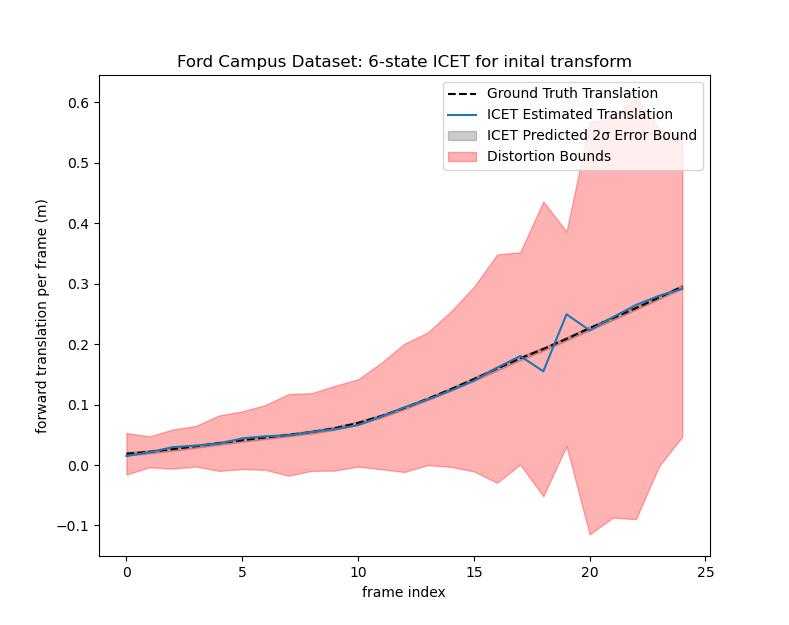

In [72]:
#plot updated bounds
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
pred_stds = pred_stds[(start_idx):(start_idx+runlen),:]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),1] + ground_truth[start_idx:(start_idx+runlen),1])/2 #v5

ax.plot(vf, 'k--', label = 'Ground Truth Translation')
ax.plot(estimates[start_idx:(start_idx+runlen),1], label = "ICET Estimated Translation") #was this

ax.fill_between(np.linspace(0,runlen-1,runlen),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'ICET Predicted 2σ Error Bound')

ax.fill_between(np.linspace(0,runlen-1,runlen),
                   vf - m_hat_history[:,0], vf + m_hat_history[:,0], 
                   color = [1,0,0], alpha = 0.3, label = 'Distortion Bounds')
ax.set_title("Ford Campus Dataset: 6-state ICET for inital transform")
ax.set_xlabel("frame index")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

# Try distortion correction on Newer College Dataset

###  As predicted, algorithm is having a trouble with cases where large swaths of the scene are missing points

In [ ]:
#load data
idx = 140 #245
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + 1) + ".npy"
pc2 = np.load(fn2)

#flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
pc1 = np.flip(pc1, axis = 0)
pc2 = np.flip(pc2, axis = 0)

#run ICET to get initial transforms of point clouds
it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

In [ ]:
#apply output of ICET to raw point clouds
trans = it.X[:3].numpy()
rot = R_tf(-it.X[3:]).numpy().T
pc2_transformed =  (pc2 @ rot) + trans 

In [ ]:
#for debug: inject exaggerated distortion to one of the clouds
m_hat_distort = np.array([0., 0.,0., 0., 0., 0.])
pc2_transformed = lc(pc2_transformed, m_hat)

plt3 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(pc1,  c = 'red'))
# disp.append(Points(pc2[:15_000], c = 'blue')) #test

disp.append(Points(pc2_transformed, c = 'blue'))
plt3.show(disp, "test viz")
ViewInteractiveWidget(plt3.window)

In [ ]:
m_hat0 = np.array([0.,0, 0, 0, 0, 0])
dc = LC(cloud1 = pc1, cloud2 = pc2_transformed, fid = 50, niter = 50, draw = True, m_hat0 = m_hat0)
ViewInteractiveWidget(dc.plt.window)